In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image, UnidentifiedImageError
import shutil

# Configuration
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.4
SEED = 42
ROOT_PATH = ''
DATASET_PATH = os.path.join(ROOT_PATH,"raw_data")
CORRUPT_PATH = os.path.join(ROOT_PATH,"corrupt_images")
os.makedirs(CORRUPT_PATH, exist_ok=True)

for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".gif"]:
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    img.verify()  # Check integrity
            except (UnidentifiedImageError, OSError, IOError) as e:
                # Move the corrupt image
                print(f"Corrupt image found: {path} — moving to {CORRUPT_PATH}")
                dest_path = os.path.join(CORRUPT_PATH, os.path.relpath(path, DATASET_PATH))
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.move(path, dest_path)

LANDMARK_DIR = os.path.join(ROOT_PATH,"data")
RAW_IMAGE_DIR = os.path.join(ROOT_PATH,"raw_data")
FILTERED_IMAGE_DIR = os.path.join(ROOT_PATH,"filtered_raw_data")
DATASET_PATH = FILTERED_IMAGE_DIR
# Supported image extensions
IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.bmp']

# Create filtered output structure
os.makedirs(FILTERED_IMAGE_DIR, exist_ok=True)

for class_name in os.listdir(LANDMARK_DIR):
    if class_name == 'debug':
        continue
    landmark_class_dir = os.path.join(LANDMARK_DIR, class_name)
    raw_class_dir = os.path.join(RAW_IMAGE_DIR, class_name)
    filtered_class_dir = os.path.join(FILTERED_IMAGE_DIR, class_name)
    os.makedirs(filtered_class_dir, exist_ok=True)

    for file in os.listdir(landmark_class_dir):
        if not file.endswith("_landmarks.json"):
            continue

        # Get base filename without "_landmarks.json"
        base_name = file.replace("_landmarks.json", "")

        # Look for corresponding image in raw directory
        for ext in IMAGE_EXTENSIONS:
            image_file = os.path.join(raw_class_dir, base_name + ext)
            if os.path.exists(image_file):
                # Copy to filtered folder
                shutil.copy(image_file, os.path.join(filtered_class_dir, os.path.basename(image_file)))
                break

# Load training dataset with validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
num_classes = len(train_ds.class_names)
label_map = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = val_ds.shard(2,0)
val_ds = val_ds.shard(2,1)
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 5643 files belonging to 51 classes.
Using 3386 files for training.
Found 5643 files belonging to 51 classes.
Using 2257 files for validation.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [3]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 145ms/step - accuracy: 0.0821 - loss: 3.8709 - val_accuracy: 0.3357 - val_loss: 2.4915
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2959 - loss: 2.4460 - val_accuracy: 0.5071 - val_loss: 1.8254
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4433 - loss: 1.9017 - val_accuracy: 0.5750 - val_loss: 1.5179
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5172 - loss: 1.5514 - val_accuracy: 0.6045 - val_loss: 1.3667
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.5785 - loss: 1.3306 - val_accuracy: 0.6205 - val_loss: 1.2773
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.6324 - loss: 1.1819 - val_accuracy: 0.6143 - val_loss: 1.2361
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6704 - loss: 1.0707 - val_accuracy: 0.6313 - val_loss: 1.1976
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.7010 - loss: 0.9367 - val_ac

In [4]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.6434 - loss: 1.4337
Test Accuracy: 0.6376
Test Loss: 1.4552


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

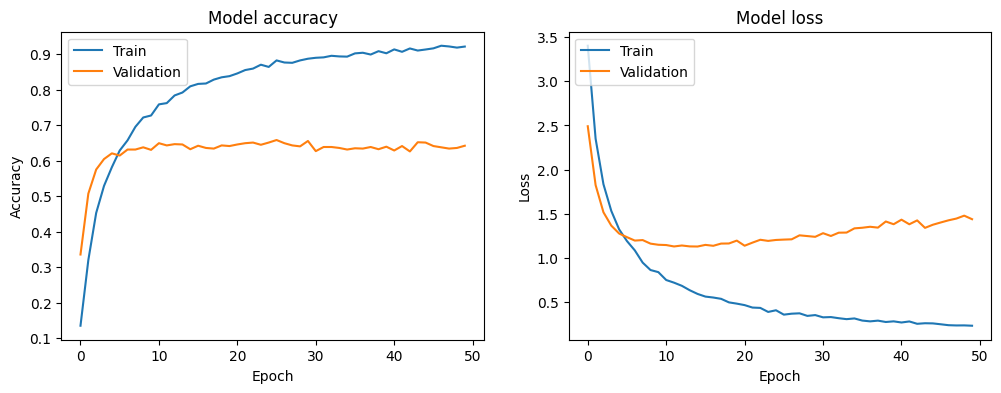

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

            A      0.667     0.632     0.649        19
            B      0.389     0.259     0.311        27
            C      0.275     0.609     0.378        23
            D      0.257     0.429     0.321        21
            E      0.643     0.600     0.621        30
            F      0.381     0.320     0.348        25
            G      0.585     0.774     0.667        31
            H      0.654     0.586     0.618        29
            I      0.286     0.273     0.279        22
            J      0.400     0.500     0.444        24
            K      0.611     0.344     0.440        32
            L      0.571     0.615     0.593        26
            M      0.355     0.256     0.297        43
            N      0.179     0.250     0.209        28
            O      0.476     0.385     0.426        26
            P      0.333     0.208     0.256        24
            Q      0.348     0.444     0.390        18
         

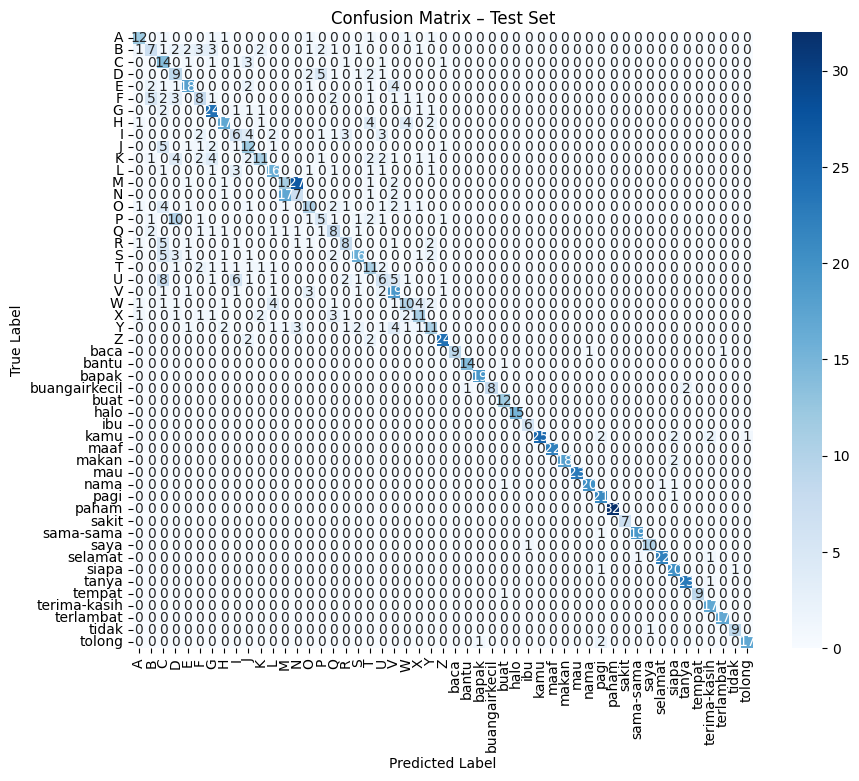

In [7]:
y_true, y_pred = [], []
target_names = [label_map[i] for i in range(len(label_map))]
for X_batch, y_batch in test_ds:
    y_true.append(y_batch.numpy())

    batch_pred = model.predict(X_batch, verbose=0)
    y_pred.append(np.argmax(batch_pred, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(
    y_true, y_pred,
    digits=3,                            
    target_names=target_names 
))

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
labels = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()